Starting to read file: C:\Users\maggi\Downloads\ML\Weather\O-A0038-003.xml
Grid size: 67 x 120
Data cleaned. Total numbers: 8040
Data prepared for classification and regression.
Total points: 8040
Valid points for regression: 3495
Classification accuracy: 0.9817578772802653


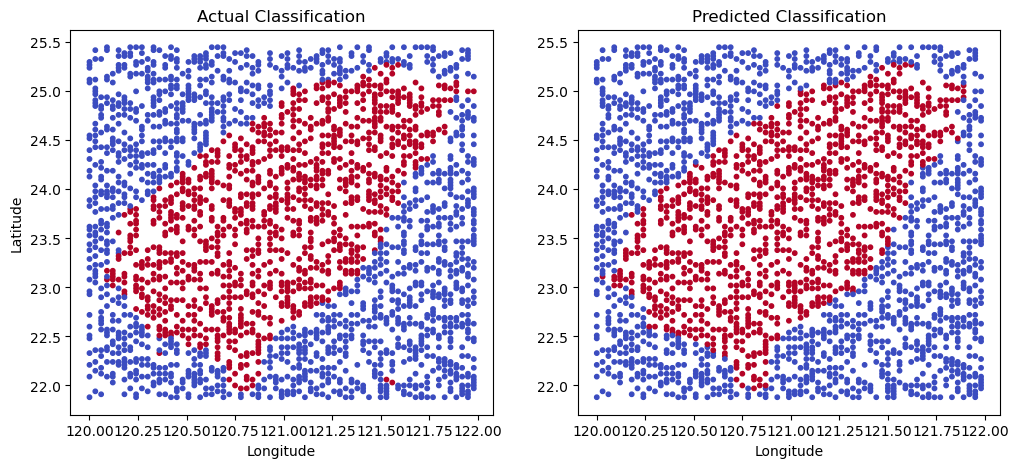

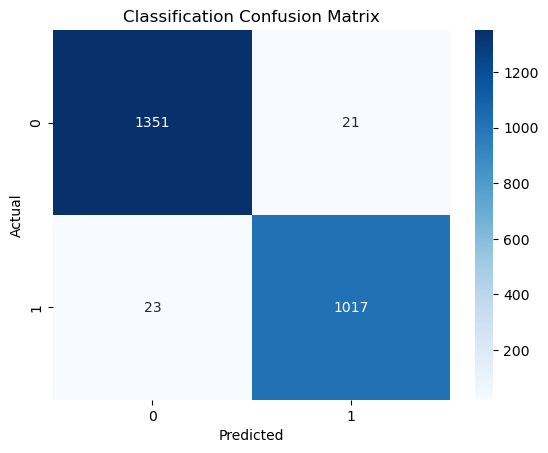

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1372
           1       0.98      0.98      0.98      1040

    accuracy                           0.98      2412
   macro avg       0.98      0.98      0.98      2412
weighted avg       0.98      0.98      0.98      2412



In [9]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score


folder_path = r'C:\Users\maggi\Downloads\ML\Weather'
file_name = 'O-A0038-003.xml'
full_path = os.path.join(folder_path, file_name)

nx = 67
ny = 120

print("Starting to read file:", full_path)
print("Grid size:", nx, "x", ny)


tree = ET.parse(full_path)
root = tree.getroot()
ns = 'urn:cwa:gov:tw:cwacommon:0.1'

content_text = None
for content in root.findall(f'.//{{{ns}}}Content'):
    if content.text and "," in content.text:
        content_text = content.text
        break

if content_text is None:
    raise ValueError("No valid <Content> block found!")


clean_text = content_text.replace("\n", "").strip()
clean_text = re.sub(r'(E[+-]\d{2})(-)', r'\1,\2', clean_text)

numbers = []
for item in clean_text.split(","):
    item = item.strip()
    if item != "":
        numbers.append(float(item))

if len(numbers) != nx * ny:
    raise ValueError(f"Data size ({len(numbers)}) does not match grid ({ny}x{nx})!")

print("Data cleaned. Total numbers:", len(numbers))


values_grid = np.array(numbers).reshape(ny, nx)
lon_start, lat_start, step = 120.0, 21.88, 0.03

lon_list = [lon_start + i*step for i in range(nx)]
lat_list = [lat_start + i*step for i in range(ny)]
lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)


df = pd.DataFrame({
    'longitude': lon_grid.flatten(),
    'latitude': lat_grid.flatten(),
    'value': values_grid.flatten()
})


df_class = df.copy()
labels = []
for v in df_class['value']:
    if v == -999.0:
        labels.append(0)
    else:
        labels.append(1)
df_class['label'] = labels


df_reg = df[df['value'] != -999.0].copy()

print("Data prepared for classification and regression.")
print("Total points:", len(df))
print("Valid points for regression:", len(df_reg))


# Classification
X_class = df_class[['longitude', 'latitude']]
y_class = df_class['label']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Regression
X_reg = df_reg[['longitude', 'latitude']]
y_reg = df_reg['value']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)


knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(Xc_train, yc_train)
yc_pred = knn_clf.predict(Xc_test)
accuracy = accuracy_score(yc_test, yc_pred)
print("Classification accuracy:", accuracy)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Xc_test['longitude'], Xc_test['latitude'], c=yc_test, cmap='coolwarm', s=10)
plt.title("Actual Classification")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(1,2,2)
plt.scatter(Xc_test['longitude'], Xc_test['latitude'], c=yc_pred, cmap='coolwarm', s=10)
plt.title("Predicted Classification")
plt.xlabel("Longitude")
plt.show()


cm = confusion_matrix(yc_test, yc_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Classification Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(yc_test, yc_pred))

Regression evaluation:
Total points: 8040
Valid points for regression: 3495
Mean Squared Error (MSE): 5.2986
R-squared (R²): 0.8560


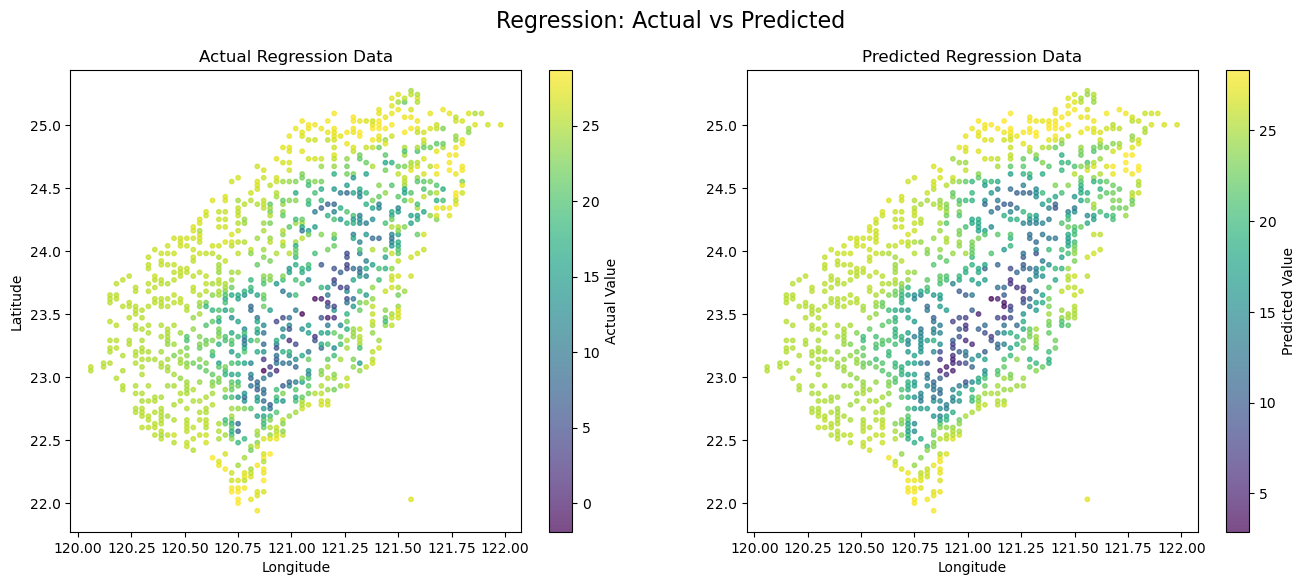

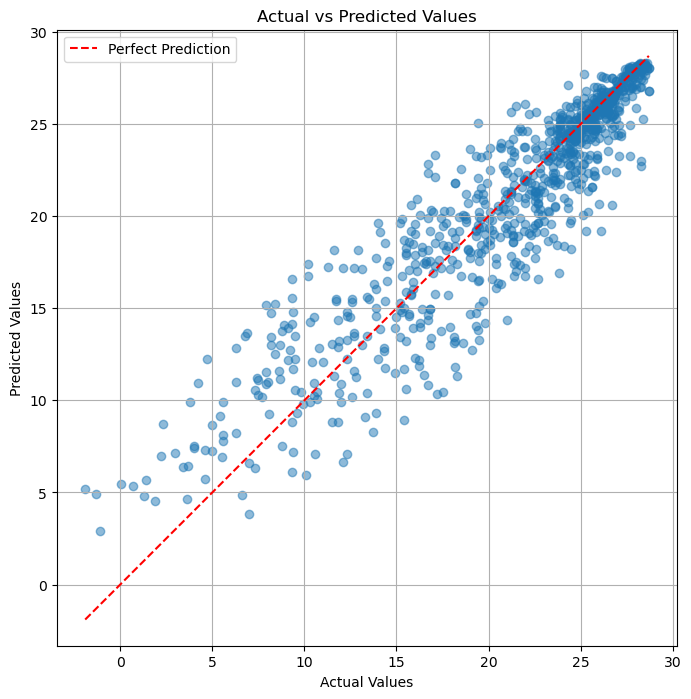

In [12]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(Xr_train, yr_train)
yr_pred = knn_reg.predict(Xr_test)

mse = mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)
print("Regression evaluation:")
print("Total points:", len(df))
print("Valid points for regression:", len(df_reg))
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualization: Regression
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(Xr_test['longitude'], Xr_test['latitude'], c=yr_test, cmap='viridis', s=10, alpha=0.7)
plt.title("Actual Regression Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Actual Value')

plt.subplot(1,2,2)
plt.scatter(Xr_test['longitude'], Xr_test['latitude'], c=yr_pred, cmap='viridis', s=10, alpha=0.7)
plt.title("Predicted Regression Data")
plt.xlabel("Longitude")
plt.colorbar(label='Predicted Value')

plt.suptitle("Regression: Actual vs Predicted", fontsize=16)
plt.show()

# Scatter: actual vs predicted
plt.figure(figsize=(8,8))
plt.scatter(yr_test, yr_pred, alpha=0.5)
perfect_line = np.linspace(min(yr_test.min(), yr_pred.min()), max(yr_test.max(), yr_pred.max()), 100)
plt.plot(perfect_line, perfect_line, 'r--', label='Perfect Prediction')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()